In [14]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, ShuffleSplit,train_test_split
from sklearn.metrics import mean_squared_error as mse
import numpy as np
from itertools import combinations
import statsmodels.api as sm
import statsmodels.tools as st
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def import_data(experimental_file, response_file, response):
    'imports data'
    'experimental_file = experimental design csv filename i.e experimental.csv'
    'response_file = results csv filename i.e Response.csv'
    'response = reponse name: i.e rheomix final deg time min or rheomix stability time min'
    
    experimental_df = pd.read_csv(experimental_file)
    response_df = pd.read_csv(response_file)
    
    X = experimental_df[experimental_df.columns.values.tolist()[1:]].values
    y = response_df[response].values
    max1 = max(y)
    min1 = min(y)

    y_norm = [2*((i-min1)/(max1-min1)) - 1 for i in y]

    linear_terms = experimental_df.columns.values.tolist()[1:]
    x_train, x_test, y_train, y_test = train_test_split(X, y_norm, test_size=9/46, random_state=0)
    
    return x_train, x_test, y_train, y_test, linear_terms, experimental_df, response_df, X, y_norm
    

In [3]:
def X_gen(model, X_linear):

    for i, j in enumerate(model):
        
        if i == 0 and len(j) == 2: 
            X_new = X_linear[:, model[0][1]]
        
        else:
            
            if len(j) == 2:
                add = X_linear[:, j[1]]

            if len(j) == 3:
                add = X_linear[:, j[1]]*X_linear[:, j[2]]

            X_new2 = np.column_stack((X_new, add))
            X_new = X_new2

    
    return X_new

In [4]:
start = time.time()


# linear_terms = experimental_df.columns.values.tolist()[1:]



def fit_model(experimental_file, response_file, response):
    

    total_subset = []

    x_train, x_test, y_train, y_test, linear_terms, experimental_df, response_df, X_total, y_norm_total = import_data(experimental_file, response_file, response)
    y = y_train
    X_linear = x_train
    y1 = np.array(y)
    lin_terms = []
    AIC_prev = 1000
    AICc_prev = 1000
    BIC_prev = 1000


    for i in range(len(linear_terms)):
        term = linear_terms[i]
        key = i
        lin_terms.append([term, i])

    cnt = 0
    for i in range(len(lin_terms)):
        for j in combinations(lin_terms, i+1):
            linear_terms = list(j)


            model = [a for a in linear_terms]
            cnt+=1
            
            X = X_gen(model, X_linear)

            model_fit = sm.OLS(y, X)
            results = model_fit.fit()
            AICc_cur = st.eval_measures.aicc(results.llf, results.nobs, results.df_model)
            AIC_cur = results.aic
            BIC_cur = results.bic
            
                    
                    
            if AIC_cur < AIC_prev:

                AIC_prev = AIC_cur
                final_model_AIC = [model, results, AIC_cur]
                
            if AICc_cur < AICc_prev:

                AICc_prev = AICc_cur
                final_model_AICc = [model, results, AICc_cur]
                
            if BIC_cur < BIC_prev:

                BIC_prev = BIC_cur
                final_model_BIC = [model, results, BIC_cur]




            poss_terms = []
            for i in range(len(linear_terms)):
                for j in range(len(linear_terms)): 
                    if i < j:
                        poss_terms.append([linear_terms[i][0] + '*' + linear_terms[j][0],  linear_terms[i][1], linear_terms[j][1]])



            for m in range(1, len(poss_terms) + 1):
                for k in combinations(poss_terms, m):

                    model = [a for a in linear_terms]
                    for i in range(m):
                        model.append(k[i])
                    
                    if len(model) < 14:
                        
                        cnt +=1
                        X = X_gen(model, X_linear)

                        model_fit = sm.OLS(y, X)
                        results = model_fit.fit()
                        AICc_cur = st.eval_measures.aicc(results.llf, results.nobs, results.df_model)
                        AIC_cur = results.aic
                        BIC_cur = results.bic



                        if AIC_cur < AIC_prev:

                            AIC_prev = AIC_cur
                            final_model_AIC = [model, results, AIC_cur]

                        if AICc_cur < AICc_prev:

                            AICc_prev = AICc_cur
                            final_model_AICc = [model, results, AICc_cur]

                        if BIC_cur < BIC_prev:

                            BIC_prev = BIC_cur
                            final_model_BIC = [model, results, BIC_cur]


    #AIC:
    model = final_model_AIC[0]
    X = X_gen(model, X_linear)
    regr = LinearRegression(fit_intercept=False)
    regr.fit(X, y_train)
    X_test = X_gen(model, x_test)
    y_pred = regr.predict(X_test)
    AIC_mse = mse(y_test, y_pred)
    final_model_AIC.append(AIC_mse)
    X_t = X_gen(model, X_total)
    model_fit = sm.OLS(y_norm_total, X_t)
    results = model_fit.fit()
    final_model_AIC.append(results.aic)
    
    model_fit = sm.OLS(y_train, X)
    results = model_fit.fit()
    final_model_AIC.append(results.aic)
    
    #AICc:
    model = final_model_AICc[0]
    X = X_gen(model, X_linear)
    regr = LinearRegression(fit_intercept=False)
    regr.fit(X, y_train)
    X_test = X_gen(model, x_test)
    y_pred = regr.predict(X_test)
    AICc_mse = mse(y_test, y_pred)
    final_model_AICc.append(AICc_mse)
    X_t = X_gen(model, X_total)
    model_fit = sm.OLS(y_norm_total, X_t)
    results = model_fit.fit()
    final_model_AICc.append(st.eval_measures.aicc(results.llf, results.nobs, results.df_model))
    
    #BIC:
    model = final_model_BIC[0]
    X = X_gen(model, X_linear)
    regr = LinearRegression(fit_intercept=False)
    regr.fit(X, y_train)
    X_test = X_gen(model, x_test)
    y_pred = regr.predict(X_test)
    BIC_mse = mse(y_test, y_pred)
    final_model_BIC.append(BIC_mse)
    X_t = X_gen(model, X_total)
    model_fit = sm.OLS(y_norm_total, X_t)
    results = model_fit.fit()
    final_model_BIC.append(results.bic)
    
    
    
    return final_model_AIC, final_model_AICc, final_model_BIC


In [5]:
experimental_file = 'experimental.csv'
response_file = 'Response.csv'


test1 = 'rheomix final deg time min'
test2 = 'rheomix stability time min'
response = test1



final_model_AIC, final_model_AICc, final_model_BIC = fit_model(experimental_file, response_file, response)
print(final_model_AIC, final_model_AICc, final_model_BIC)

[[['Xpvc', 0], ['Xfiller', 1], ['Xstabiliser', 3], ['Xdinp', 4], ['Xldh', 5], ['Xpvc*Xdinp', 0, 4], ['Xstabiliser*Xldh', 3, 5], ['Xdinp*Xldh', 4, 5]], <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000000D36D70D3C8>, 3.8789765234291025, 0.1305039653122414, 14.84886435486753, 3.8789765234291025] [[['Xpvc', 0], ['Xstabiliser', 3], ['Xdinp', 4], ['Xldh', 5], ['Xstabiliser*Xldh', 3, 5], ['Xdinp*Xldh', 4, 5]], <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000000D36D70D710>, 6.830522866850689, 0.1287027099825193, 16.665718481774185] [[['Xpvc', 0], ['Xstabiliser', 3], ['Xdinp', 4], ['Xldh', 5], ['Xstabiliser*Xldh', 3, 5], ['Xdinp*Xldh', 4, 5]], <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000000D36D70D710>, 13.696030342716035, 0.1287027099825193, 25.483720706862602]


In [57]:
x_label = ['','AIC$_{c}$', 'BIC', 'k-fold']
x = [1,2,3]
y1 = [1,2,3]
y2 = [1,2,4]
y3 = [3,2,3]
y4 = [1,4,3]
y5 = [1,2,1]

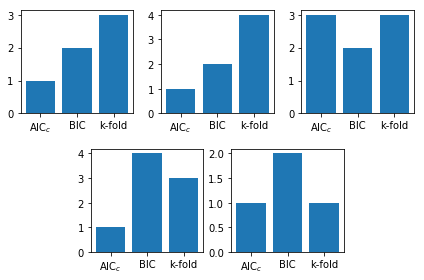

In [58]:
fig, axs = plt.subplots(5)
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
ax1.bar(x, y1)
ax1.set_xticklabels(x_label)
ax2.bar(x, y2)
ax2.set_xticklabels(x_label)
ax3.bar(x, y3)
ax3.set_xticklabels(x_label)
ax4.bar(x, y4)
ax4.set_xticklabels(x_label)
ax5.bar(x, y5)
ax5.set_xticklabels(x_label)
fig.tight_layout()

In [6]:
# df = pd.DataFrame(total_subset)
# df.to_csv("(K=10)_NoVIF_Total_model_subset_"  + response + ".csv")


In [7]:
# final_model, final_model[1].summary(), final_model_kfold, final_model_kfold[1].summary()

In [8]:
# plt.plot(CN_hist, AIC_hist, 'r*')
# plt.axis([0, 2000, 12, 20])
# plt.xlabel('CN')
# plt.ylabel('AIC')
# plt.show()

In [9]:
# plt.plot(VIF_max_hist, AIC_hist1, 'r*')
# plt.show()

In [10]:
# plt.scatter(CN_hist1, AIC_hist1, c = VIF_max_hist, vmin=0, vmax=50)
# # plt.axis([0, 1000, 12, 20])
# plt.xlabel('CN')
# plt.ylabel('AIC')
# plt.colorbar()
# # plt.set_label('VIF')
# plt.show()

In [11]:
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = Axes3D(fig)

# ax.scatter(CN_hist1,VIF_max_hist, AIC_hist1)
# plt.xlabel('CN')
# plt.ylabel('VIF')
# ax.set_zlabel('AIC')
# # plt.axis([0, 1000, 12, 18])
# # plt.colorbar()
# plt.show()

In [12]:
# len(model_subset)

In [13]:
# for i in model_subset:
#     if i[2] < 550 and i[2] > 450:
#         a = []
#         for j in i[0]:
#             a.append(j[0])
#         print('----model:', a, 'AIC', round(i[1], 3), 'CN:', round(i[2], 3), 'vif_max:', round(i[3], 3), 'R2:', round(i[4], 3), '----'
#              )
        

# 